In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 12.5 MB/s eta 0:00:00


In [8]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import xgboost
from balance_dataset import balance_dataset
import pandas as pd
from statistics import mean, stdev
from sklearn.preprocessing import StandardScaler

In [69]:
# function and assign labels for second task
def assign_targets(analytic, handcraft_features):
    for i in range(0, len(analytic)):
        if analytic['target'][i] == 1:
            first_healthy = i
            break
    # assign the target column
    handcraft_features['target'] = 0
    for i in range(0, int(first_healthy / 48)):
        handcraft_features.loc[i, 'target'] = 0
    for i in range(int(first_healthy / 48), len(handcraft_features)):
        handcraft_features.loc[i, 'target'] = 1
    return handcraft_features


def create_handcraft_features(data):
    # mean value of activity for every 30 mins
    means = []

    # activity for every 1 min of a whole day
    max_activity = []
    min_activity = []
    stds = []

    # patient's id
    # p_id = []

    data2 = pd.DataFrame()

    activity_list = []
    for i in range(0, len(data)):
        activity_list.append(data.iloc[i]["activity"])
        if ((i - 1) % 48 == 0 and i != 0):
            means.append(mean(activity_list))
            stds.append(stdev(activity_list))
            max_activity.append(max(activity_list))
            min_activity.append(min(activity_list))
            # p_id.append(data.iloc[i]["patient"])
            activity_list = []

    data2["means"] = means
    data2["stds"] = stds
    data2["max"] = max_activity
    data2["min"] = min_activity
    # data2["patient"] = p_id
    # print(p_id)

    return data2

In [76]:
analytic_train = pd.read_csv('Data/train1.csv')
analytic_test = pd.read_csv('Data/test1.csv')
analytic_validation = pd.read_csv("Data/validation1.csv")

df_train = assign_targets(analytic_train, create_handcraft_features(analytic_train))
df_test = assign_targets(analytic_test, create_handcraft_features(analytic_test))
df_validation = assign_targets(analytic_validation, create_handcraft_features(analytic_validation))

# balance the dataset
df_train = balance_dataset(df_train)
df_test = balance_dataset(df_test)
df_validation = balance_dataset(df_validation)

# split to features and targets
X_train = df_train.drop(['target'], axis=1)
y = df_train['target']
X_test = df_test.drop(['target'], axis=1)
y_test = df_test['target']
scaler = StandardScaler()
X = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [77]:
# train XGBoost model
model = xgboost.XGBClassifier(learning_rate=0.05, n_estimators=600, objective='binary:logistic',
                              nthread=1, max_depth=2, min_child_weight=2, gamma=0.3, colsample_bytree=1.0,
                              subsample=1, random_state=2023)

In [78]:
# split to features and targets
X_train = df_train.drop(['target'], axis=1)
y = df_train['target']
X_test = df_test.drop(['target'], axis=1)
y_test = df_test['target']
scaler = StandardScaler()
X = scaler.fit_transform(X_train)
X = pd.DataFrame(X, index=X_train.index, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [79]:
model.fit(X,y)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.57%


In [80]:
def f(x):
    return shap.links.identity(model.predict_proba(x, validate_features=False)[:,1])

# explain the model's predictions using SHAP values
masker = shap.maskers.Independent(data = X)
explainer = shap.Explainer(f, masker = masker)
shap_values = explainer(X)

In [81]:
y[0]

0

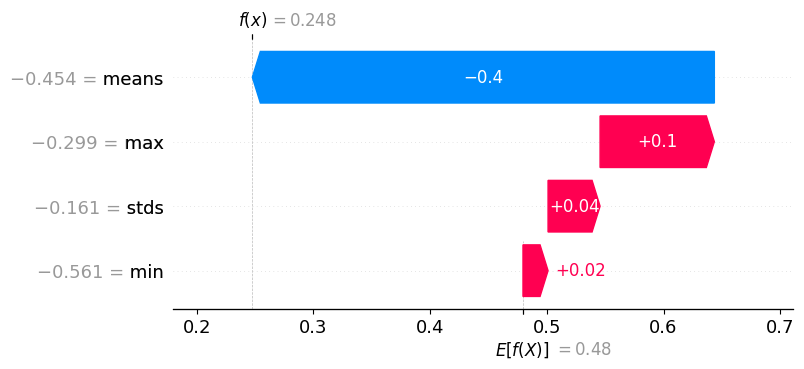

In [82]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

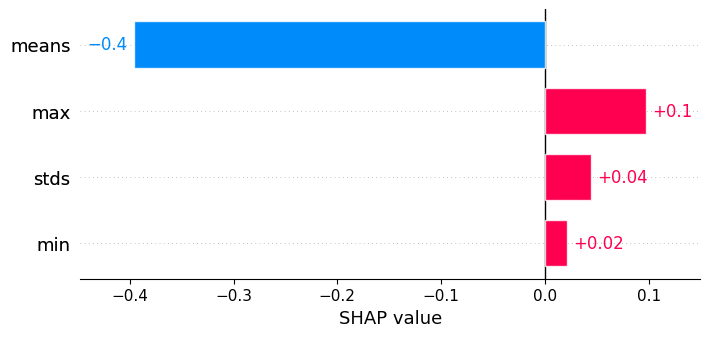

In [83]:
# plot the global importance of each feature
shap.plots.bar(shap_values[0])

In [84]:
shap.plots.initjs()

# visualize the first prediction's explanation
shap.plots.force(shap_values[0])

In [85]:
shap.plots.initjs()

# visualize the first prediction's explanation
shap.plots.force(shap_values)

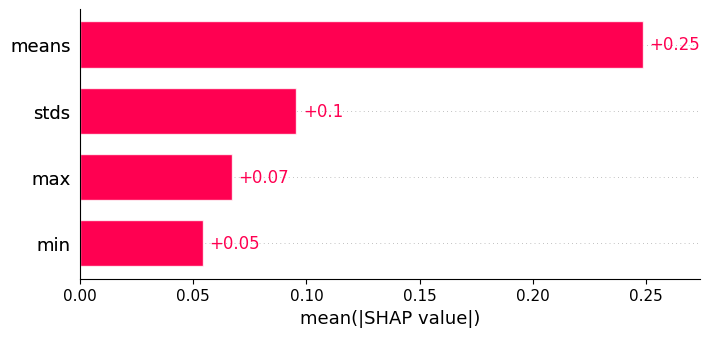

In [86]:
# plot the global importance of each feature
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


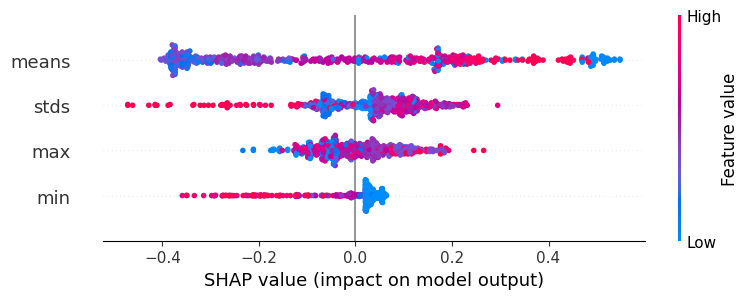

In [87]:
# plot the distribution of importances for each feature over all samples
shap.summary_plot(shap_values, X)